# EDA - ECG, CXR and CTPA Cohort

Statistics and insight about the cohort and the dimensions before / after preprocessing.

## CTPA

1. Public cohorts - ~7200 records, 32% positive, The average CTPA scan has the highest resolution, with a series length of about 240 slices.
2. Sheba Cohort - ~9200 records, 16% positive, The average CTPA scan has the highest resolution, with a series length of about 400 slices.

Both public and Sheba cohorts, slices of shape  (512 x 512).

Preprocess:

1. Load all dicoms, extract the highest resolution series (longest) and filter CT which are in standard axial orientation.
2. Extract scan attributes: thickness, spacing, position, orientation, slope and intercept.
3. Convert scan pixels values into Housefield units. 
4. Get lung Volume of Interest (VOI) - crop the CT volume (new dims ~ 200 x 300 x 385), resample and resize into new dimensions (128 x 256 x 256), normalize and clipping into [-1,1] value range.
5. Encode the CT using pretrained VAE, embedding shape (4, 32, 32, 128), scale latent space for ddpm (latents * 0.18215)



In [1]:
cd ..

D:\Maor\X-ray2CTPA


In [2]:
from preprocess.preprocess_ctpa import *
from pathlib import Path
import matplotlib.pyplot as plt
import os

weight_dtype = torch.float32
longest_series_len_list = []
hu_min, hu_max = float('inf'), -float('inf')

local_path = "weights/vae-ft-mse-840000-ema-pruned.safetensors"  # url="https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"
config_path = "weights/config.json"
vae = AutoencoderKL.from_single_file(local_path, local_files_only=True, config=config_path)
vae.to(DEVICE, dtype=weight_dtype)

def print_metadata(ctpa_path):
    highers_series = get_high_resolusion_dicom_series(ctpa_path)
    slices, attr = dicom_load_scan(highers_series) 
    ct = dicom_get_pixels_hu(slices)
    hu_min = np.min(ct)
    hu_max = np.max(ct)
    print(f"percentile hu ct scan [0,5,25,50,75,95,98,99,100]: {np.percentile(ct, [0, 5, 25, 50, 75, 95, 98, 99, 100])}")
    print( f"series length: {len(slices)}")
    print("Observed HU range:", hu_min, hu_max)
    print("after loading exam = ", ct.shape)
    ct = preprocess_ctpa(ct, attr)
    print("after preprocessing = ", ct.shape)
    image = ct[int(len(ct)/2)]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    latents = encode_ctpa(ct, vae)

D:\Maor\X-ray2CTPA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Public Data

[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
223
percentile hu ct scan [0,5,25,50,75,95,98,99,100]: [-3024. -3024.  -994.  -137.   -19.   154.   282.   408.  2719.]
series length: 223
Observed HU range: -3024 2719
after loading exam =  (223, 512, 512)


D:\Maor\X-ray2CTPA\.venv\Lib\site-packages\lungmask\mask.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(modelpath, map_location=torch.device("c

lungmask 2025-10-09 00:40:37 Postprocessing



100%|██████████| 2/2 [00:00<?, ?it/s]


Cropping scan to lung VOI:    (201, 280, 413)
new sampling =  [1.00099602 0.99961607 0.99933839]
after preprocessing =  (128, 256, 256)


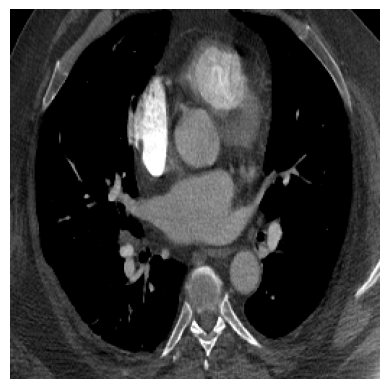

ct before vae =  torch.Size([1, 1, 128, 256, 256])
latents shape (4, 32, 32, 128)


In [3]:
train_ctpa = Path(r"data\train")
print_metadata(train_ctpa / os.listdir(train_ctpa)[0])

NA
1057
percentile hu ct scan [0,5,25,50,75,95,98,99,100]: [-3024. -3024. -3024.  -995.  -121.    66.   181.   282.  3071.]
series length: 1057
Observed HU range: -3024 3071
after loading exam =  (1057, 512, 512)


D:\Maor\X-ray2CTPA\.venv\Lib\site-packages\lungmask\mask.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(modelpath, map_location=torch.device("c

lungmask 2025-10-09 00:57:22 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 11.57it/s]


Cropping scan to lung VOI:    (612, 214, 283)
new sampling =  [1.00093458 0.99992473 1.00132988]
after preprocessing =  (128, 256, 256)


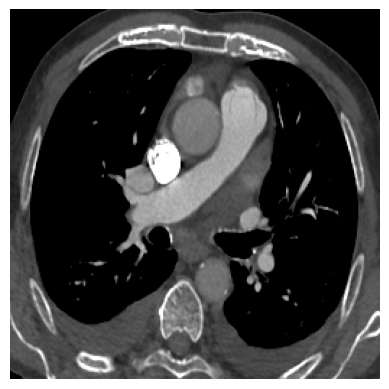

ct before vae =  torch.Size([1, 1, 128, 256, 256])
latents shape (4, 32, 32, 128)


In [7]:
print_metadata(train_ctpa / os.listdir(train_ctpa)[2])

### Sheba data

NA
436
percentile hu ct scan [0,5,25,50,75,95,98,99,100]: [-1024. -1024. -1020.  -970.   -52.   146.   407.   652.  3071.]
series length: 436
Observed HU range: -1024 3071
after loading exam =  (436, 512, 512)


D:\Maor\X-ray2CTPA\.venv\Lib\site-packages\lungmask\mask.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(modelpath, map_location=torch.device("c

lungmask 2025-10-09 00:55:08 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 31.44it/s]


Cropping scan to lung VOI:    (246, 226, 310)
new sampling =  [0.99898477 0.99752825 1.00077479]
after preprocessing =  (128, 256, 256)


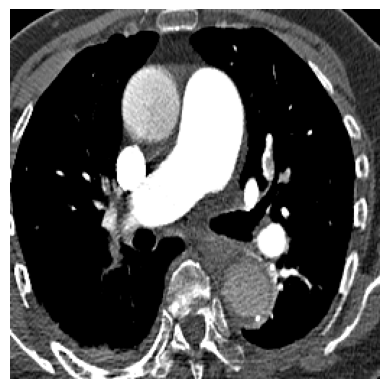

ct before vae =  torch.Size([1, 1, 128, 256, 256])
latents shape (4, 32, 32, 128)


In [5]:
sheba_ctpa = Path(r"data\ctpa")
print_metadata(sheba_ctpa / os.listdir(sheba_ctpa)[0])

NA
1057
percentile hu ct scan [0,5,25,50,75,95,98,99,100]: [-3024. -3024. -3024.  -995.  -121.    66.   181.   282.  3071.]
series length: 1057
Observed HU range: -3024 3071
after loading exam =  (1057, 512, 512)


D:\Maor\X-ray2CTPA\.venv\Lib\site-packages\lungmask\mask.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(modelpath, map_location=torch.device("c

lungmask 2025-10-09 00:56:24 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 11.24it/s]


Cropping scan to lung VOI:    (612, 214, 283)
new sampling =  [1.00093458 0.99992473 1.00132988]
after preprocessing =  (128, 256, 256)


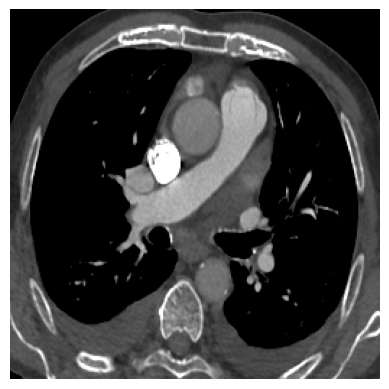

ct before vae =  torch.Size([1, 1, 128, 256, 256])
latents shape (4, 32, 32, 128)


In [6]:
print_metadata(sheba_ctpa / os.listdir(sheba_ctpa)[2])

### Chest Xray

Embedding creation using Google cxr-foundation model (2024) https://huggingface.co/google/cxr-foundation, embedding dims ( 8 x 8 x 1376 )

Source cxr shape (~ 3000 x 3500 ) 

Input for the ddpm (cxr pretrained classifier embedding) is 512 shape vector. 

In [37]:
import pydicom as dcm
def print_xray(src_path,im,cols,d,f,axs,filter=None,keep_only=None):
    file_path = os.path.join(src_path,d,f)
    ds = dcm.dcmread(file_path)
    if ds.Modality not in ('CR', 'DX'):
        return im
    if filter:
        if filter(ds):
            return im
    if keep_only:
        if not keep_only(ds):
            return im
    # if 'CHEST' not in ds.BodyPartExamined:
    #     print(ds.BodyPartExamined)
    #     return im

    i = im // cols
    j = im % cols

    img = ds.pixel_array#.astype(np.float32)  # Convert to float32
    print("Chest Xray shape: ", img.shape)
    # find mask
    # if mask = -1 (no Pneumothorax) then display image and increase counter
    # otherwise look for another image
    # mask = train_rle[train_rle.ImageId == image_id].iloc[0].values[1]
    # if mask == ' -1':
    im += 1
    axs[i,j].imshow(img, cmap='grey') #plot the data
    axs[i,j].axis('off')
    axs[i,j].set_title(f"Modality {ds.Modality}\n"
                       f"KEY {d}\n"
                       # f"Modality: {ds.Modality}\n"
                       f"PositionerType: {ds.PositionerType if ('PositionerType' in ds) else ''}\n"
                       f"ViewPosition: {ds.ViewPosition if ('ViewPosition' in ds) else ''}\n"
                       f"PatientOrientation: {ds.PatientOrientation if ('PatientOrientation' in ds) else ''}\n"
                       f"BodyPartExamined: {ds.BodyPartExamined if ('BodyPartExamined' in ds) else ''}\n"
                       # f"PhotometricInterpretation: {ds.PhotometricInterpretation if ('PhotometricInterpretation' in ds) else ''}\n"
                       # f"Manufacturer: {ds.Manufacturer if ('Manufacturer' in ds) else ''}\n"
      # f"Description:{ds.AcquisitionDeviceProcessingDescription if ('AcquisitionDeviceProcessingDescription' in ds) else ''}\n"
                        # f"ProtocolName:{ds.ProtocolName if ('ProtocolName' in ds) else ''}\n"
                       # f"Sensitivity:{ds.Sensitivity if ('Sensitivity' in ds) else ''}\n"
                       )
    return im


Chest Xray shape:  (1680, 1200, 3)
Chest Xray shape:  (2560, 3072)
Chest Xray shape:  (2336, 2373)
Chest Xray shape:  (1801, 1200, 3)
Chest Xray shape:  (3520, 4280)
Chest Xray shape:  (1606, 1200, 3)
Chest Xray shape:  (1801, 1200, 3)
Chest Xray shape:  (2336, 2373)
Chest Xray shape:  (1801, 1200, 3)


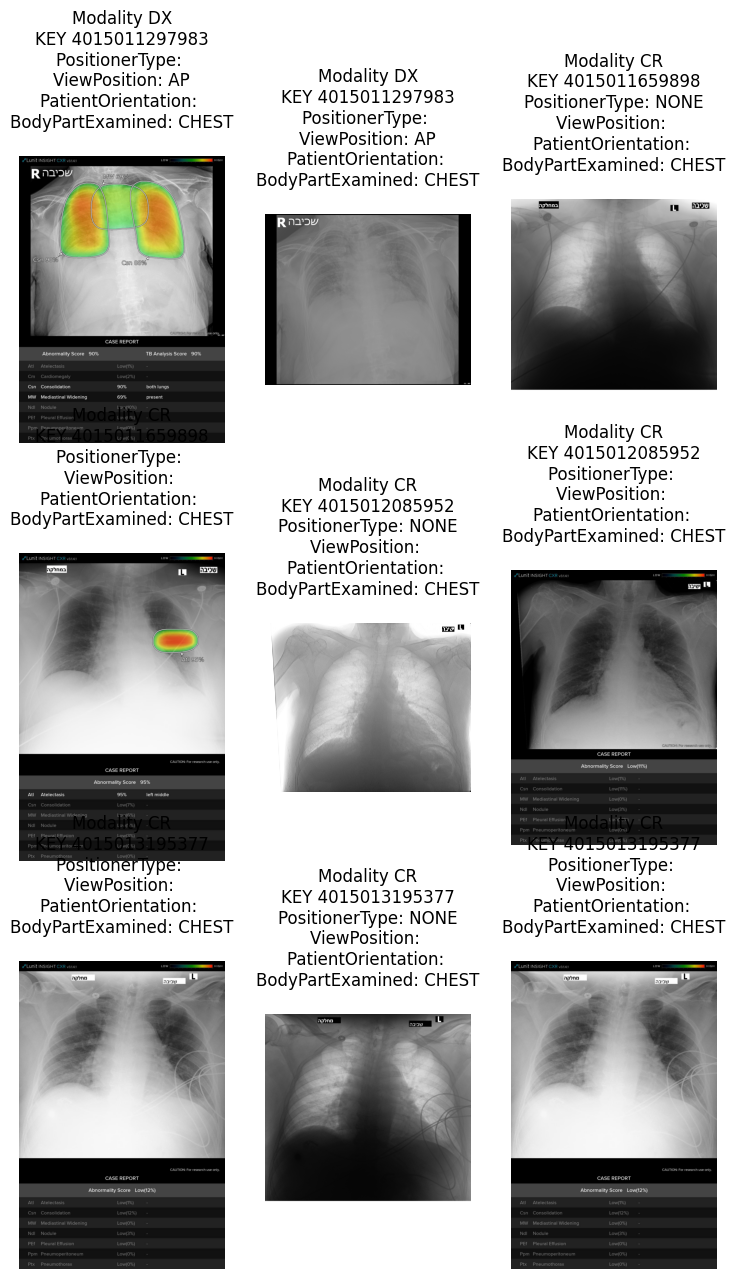

In [43]:
cxr_path=Path(r"data\xray")
cxr_list = os.listdir(cxr_path)
rows,cols=3,3
im = 0
fig, axs = plt.subplots(rows, cols,figsize=(cols*3,rows*5))
for d in cxr_list:
    for f in os.listdir(cxr_path / d):
        im = print_xray(cxr_path,im,cols,d,f,axs)
        if im == rows * cols:
            break

In [44]:
def print_all_xrays(src_path,df, rows=10,cols=3,filter=None,keep_only=None,save_path=None):
    
    fig, axs = plt.subplots(rows, cols,figsize=(cols*3,rows*5))
    if save_path:
        plt.close()
    im = 0
    for i,r in df.iterrows():
        d=str(int(r.AccessionNumber))
        f=str(r.filename)
        im = print_xray(src_path,im,cols,d,f,axs,filter=filter,keep_only=keep_only)
        if im == rows * cols:
            break

In [45]:
import pandas as pd
cxr_df = pd.read_csv(r"D:\Maor\X-ray2CTPA\data\xray_ecg_full_props_PE_data_split_gemini_label_01082025.csv")
cxr_df = cxr_df[cxr_df["AccessionNumber"].isin([float(c) for c in cxr_list])]
cxr_df

C:\Users\User\AppData\Local\Temp\ipykernel_27196\51592601.py:2: DtypeWarning: Columns (174,183,238,249,252,253) have mixed types. Specify dtype option on import or set low_memory=False.
  cxr_df = pd.read_csv(r"D:\Maor\X-ray2CTPA\data\xray_ecg_full_props_PE_data_split_gemini_label_01082025.csv")


,CT_sps_key,xray_SPS_KEY,ecg_RowID,CTTime,OrderedProcedure,OrderedProcedureType,Label_by_diagnosis,Diagnosis,regex_label,rn_ct,...,ViewPosition,WindowCenter,WindowWidth,XRayTubeCurrent,XRayTubeCurrentInuA,filename,is_PE_anytime,Label by Gemini(pro-1.5)_y,index_col,group
58,4015011660026,4.015012e+12,1794154.0,2023/02/05 22:43:02.000000000,CT בית החזה אנגיו,CTA עורקי הריאה (PE),1,GENERAL HEALTH DETERIORATION | DUE TO MALIGNAN...,1,1,...,NaN,2047.0,4095.0,160.0,160000.0,1.2.392.200036.9125.9.0.3122918774.2684387328....,2.0,1.0,4015011660026,train
67,4015012086029,4.015012e+12,1897722.0,2023/08/17 18:59:22.000000000,CT בית החזה אנגיו,CTA עורקי הריאה (PE),0,ANASARCA;EDEMA,0,1,...,NaN,2047.0,4095.0,320.0,320000.0,1.2.392.200036.9125.9.0.3206846563.67679668.34...,0.0,0.0,4015012086029,train
92,4015011299699,4.015011e+12,1529266.0,2022/08/16 14:00:10.000000000,CT בית החזה אנגיו,CTA עורקי הריאה (PE),1,"ATYPICAL PNEUMONIA;DYSPNEA [SOB, SHORTNESS OF ...",1,1,...,AP,7484.0,5047.0,0.0,0.0,1.3.6.1.4.1.19179.1.17654781039477.3.26932.265...,2.0,1.0,4015011299699,train
94,4015013200260,4.015013e+12,2141976.0,2024/12/18 13:52:46.000000000,CT בית החזה אנגיו,CTA עורקי הריאה (PE),0,"SEPSIS;ACUTE KIDNEY INJURY [AKI, ARF, RENAL FA...",0,1,...,NaN,2047.0,4095.0,200.0,200000.0,1.2.392.200036.9125.9.0.1277641811.201359360.1...,0.0,0.0,4015013200260,train


Chest Xray shape:  (2336, 2373)
Chest Xray shape:  (3520, 4280)
Chest Xray shape:  (2560, 3072)
Chest Xray shape:  (2336, 2373)


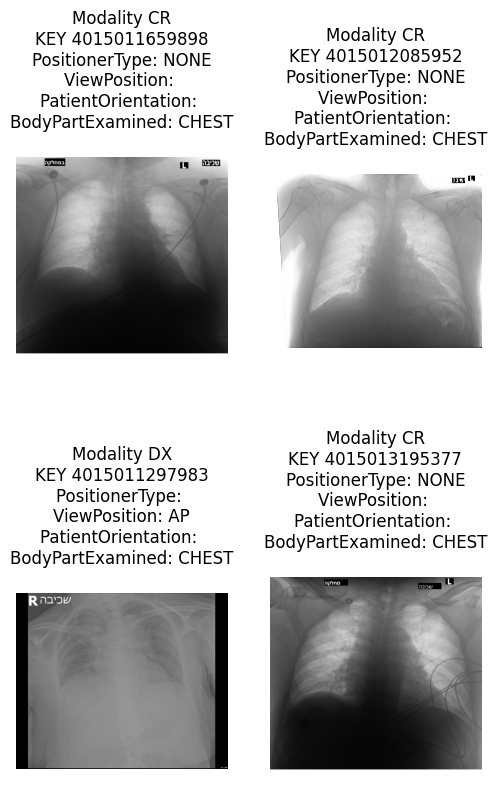

In [46]:
print_all_xrays(cxr_path,cxr_df,2, 2)

### ECG

12-leads ecg shape ( 12 x 5000 ) matrix.  

Input for the ddpm (ecg pretrained classifier embedding) is 64 shape vector (fc1 output).